In [1]:
from google.colab import drive

drive.mount('/content/drive')

use_gpu = False

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

In [3]:
datafile = '/content/drive/MyDrive/Colab_Notebooks/COMP4432_project/test/new_text_withstem.csv'
raw_data = pd.read_csv(datafile, parse_dates=[0], infer_datetime_format=True)
raw_data = pd.read_csv(datafile, parse_dates=[0], infer_datetime_format=True)

reindexed_data = raw_data['headline_text']
reindexed_data.index = raw_data['publish_date']

raw_data.head()

<ipython-input-3-c07257d82091>:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  raw_data = pd.read_csv(datafile, parse_dates=[0], infer_datetime_format=True)
<ipython-input-3-c07257d82091>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  raw_data = pd.read_csv(datafile, parse_dates=[0], infer_datetime_format=True)
<ipython-input-3-c07257d82091>:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  raw_data = pd.read_csv

,Unnamed: 0,publish_date,headline_text,headline_cleaned_text
0,0,20030219,aba decides against community broadcasting lic...,decid against communiti broadcast licenc
1,1,20030219,act fire witnesses must be aware of defamation,fire must awar defam
2,2,20030219,a g calls for infrastructure protection summit,call infrastructur protect summit
3,3,20030219,air nz staff in aust strike for pay rise,staff aust strike rise
4,4,20030219,air nz strike to affect australian travellers,strike affect australian travel


In [4]:
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)

    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

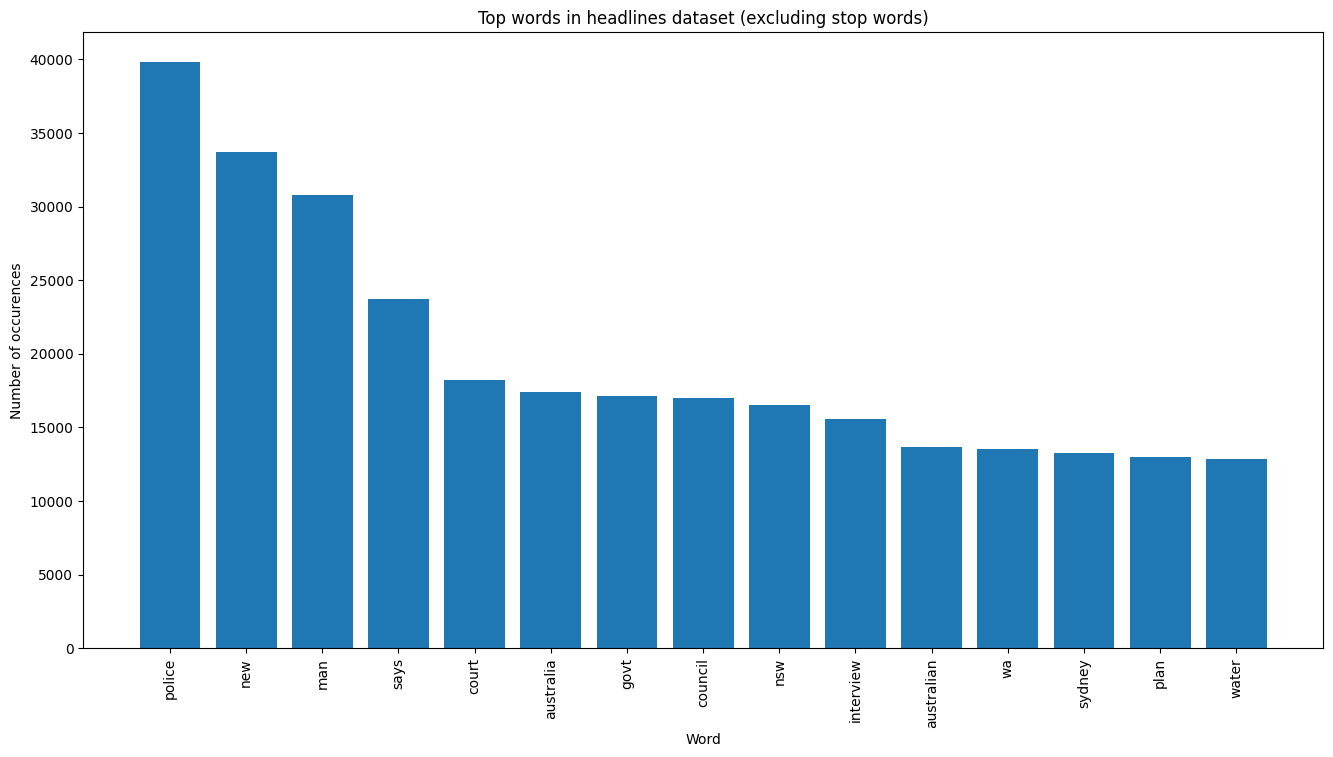

In [5]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer,
                                     text_data=reindexed_data)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [7]:
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
small_text_sample = reindexed_data.sample(n=10000, random_state=0).values

print('Headline before vectorization: {}'.format(small_text_sample[123]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('Headline after vectorization: \n{}'.format(small_document_term_matrix[123]))

Headline before vectorization: leaders of womens group plan parliament march to
Headline after vectorization: 
  (0, 8434)	1
  (0, 6467)	1
  (0, 12467)	1
  (0, 5001)	1
  (0, 8151)	1
  (0, 6923)	1


In [8]:
n_topics = 8
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(small_document_term_matrix)

In [9]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [10]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [11]:
# Define helper functions
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))
    return top_words


In [12]:
top_n_words_lsa = get_top_n_words(10, lsa_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])


Topic 1:  police death sydney missing murder adelaide woman search probe accused
Topic 2:  man court charged guilty sex jailed murder child assault death
Topic 3:  new year help home australian deal chief laws indigenous tasmanian
Topic 4:  says health australian minister sa workers election market government power
Topic 5:  govt nsw water plan qld report urged calls north rural
Topic 6:  australia day win south coronavirus world test news abc live
Topic 7:  crash car hospital dies killed road fatal injured driver wa
Topic 8:  council interview cup wins world considers plan tigers vote legal


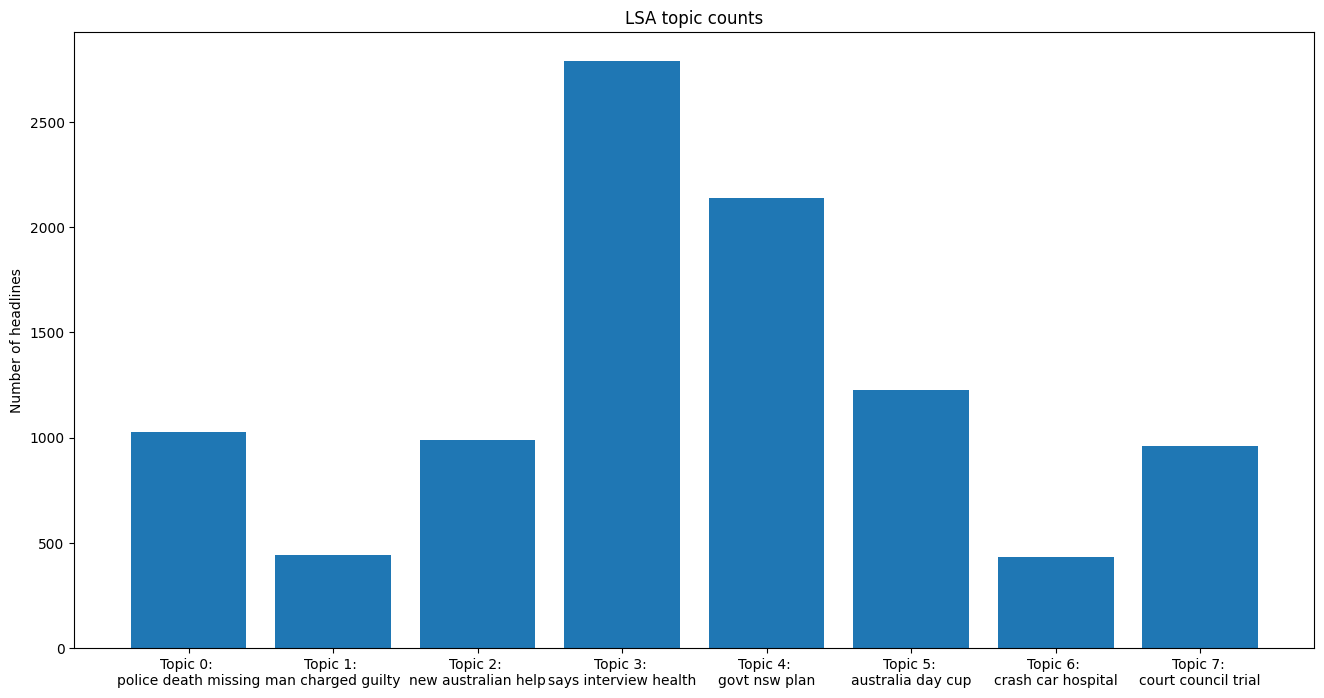

In [12]:
top_3_words = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of headlines');
ax.set_title('LSA topic counts');
plt.show()

In [13]:
lsa_counts

[982, 1087, 2653, 601, 1298, 2336, 544, 499]

In [14]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100,
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.012s...
[t-SNE] Computed neighbors for 10000 samples in 1.259s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.002383
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.667000
[t-SNE] KL divergence after 2000 iterations: 1.287229


In [15]:
# Define helper functions
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])

        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [16]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [32]:
top_3_words_lsa = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_topics))
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

for t in range(n_topics):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1],
                  text=top_3_words_lsa[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

In [6]:
%pip install octis

In [17]:
import ast

from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.evaluation_metrics.coherence_metrics import Coherence

import csv
import os
from os.path import join as opj
import pandas as pd

news_df = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/COMP4432_project/test/new_text_withstem.csv")
# Extract

cleaned_text = news_df['headline_cleaned_text']
original_text = news_df['headline_text']
num_samples = 100000
cleaned_text = cleaned_text[:num_samples]
cleaned_text = [cleaned_text[i] if isinstance(cleaned_text[i],str) else original_text[i] for i in range(len(cleaned_text))]

from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.evaluation_metrics.coherence_metrics import Coherence
import ast
from octis.dataset.dataset import Dataset
def evaluate_metric(cleaned_text:str,bertopic:list,topk:int,measure="c_uci",):
  # bertopic_topics=[]
  # for topic in bertopic:
  #   topics = ast.literal_eval(topic)
  #   bertopic_topics.append(topics)
  #   # print(topics)
  corpus = [text.split(" ") for text in cleaned_text]
  coherence = Coherence(texts=corpus,
                        topk=topk, measure=measure)

  diversity = TopicDiversity(topk=topk)

  coherence = coherence.score({"topics": bertopic})
  diversity = diversity.score({"topics": bertopic})

  print(f"topic coherence {measure} : {coherence}")
  print(f"topic diversity : {diversity}")
  import csv

  # Zip the columns together
  data = zip([coherence], [diversity])

  # Specify the CSV file path
  csv_file = '/content/drive/MyDrive/Colab_Notebooks/COMP4432_project/test/output.csv'

  # Write the data to the CSV file
  with open(csv_file, 'w', newline='') as f:
      writer = csv.writer(f)
      writer.writerow(['Coherence', 'Diversity'])  # Write header row
      writer.writerows(data)  # Write data rows
  return coherence, diversity

In [19]:
topics=[]
for top in top_n_words_lsa:
  topics.append(top.split())

In [20]:
evaluate_metric(cleaned_text,topics,8,measure="c_v")

topic coherence c_v : 0.4083721116292929
topic diversity : 0.9375


(0.4083721116292929, 0.9375)

In [21]:
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online',
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(small_document_term_matrix)

In [22]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [23]:
top_n_words_lda = get_top_n_words(10, lda_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  govt day north sydney market nt labor election final open
Topic 2:  hospital crash abc port trump budget calls deal trial indigenous
Topic 3:  cup world plan coast gold centre dies price council group
Topic 4:  interview says win iraq minister claims public australian rain change
Topic 5:  rural national home school missing farmers set funding news return
Topic 6:  police man new crash charged car child murder accused guilty
Topic 7:  australia health south qld water court new wa coronavirus death
Topic 8:  council nsw urged workers government tax fears weather union action


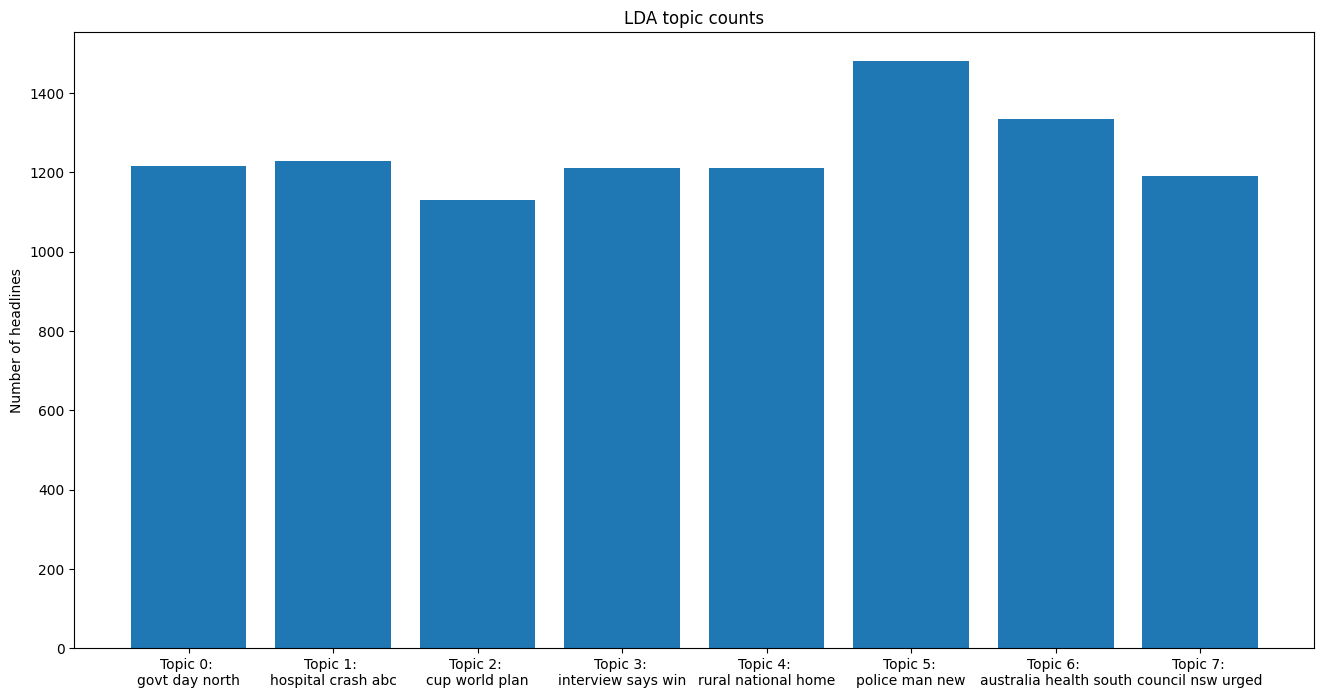

In [24]:
top_3_words = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels);
ax.set_title('LDA topic counts');
ax.set_ylabel('Number of headlines');

In [18]:
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100,
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.011s...
[t-SNE] Computed neighbors for 10000 samples in 1.275s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.396393
[t-SNE] KL divergence after 2000 iterations: 1.248268


In [24]:
top_3_words_lda = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics))
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])
bb
for t in range(n_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1],
                  text=top_3_words_lda[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

In [25]:
topics=[]
for top in top_n_words_lda:
  topics.append(top.split())

In [26]:
evaluate_metric(cleaned_text,topics,8,measure="c_v")

topic coherence c_v : 0.31303534536278443
topic diversity : 0.96875


(0.31303534536278443, 0.96875)

In [27]:
lda_counts

[1230, 1334, 1211, 1190, 1480, 1215, 1210, 1130]